In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 


%matplotlib inline
plt.style.use('seaborn-v0_8')

In [18]:
df = pd.read_csv('../Sleep_health_and_lifestyle_dataset.csv')
df.head(10)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
9,10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN


### 1. Выбор атрибута (роль целевого класса):
- Был выбран атрибут: Sleep Disorder со значениями: None, Insomnia, Sleep Apnea
- Данный атрибут отобран по следующих критериям:
    * Категориальный признак
    * Медицински значимый, так как все остальные признаки (возраст, давление, физическая активность и так далее) — это факторы риска, которые могут влиять на нарушения сна
    * Многоклассовый — позволяет сравнить разные алгоритмы

Распределение классов:
Класс		Количество
------------------------------
None            219            
Sleep Apnea     78             
Insomnia        77             

Общее количество записей: 374


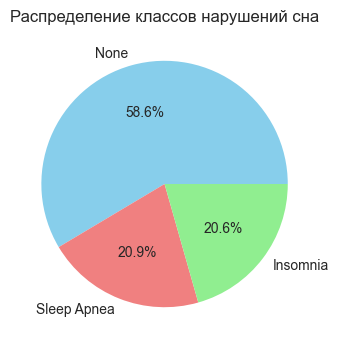

In [21]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

class_distribution = df['Sleep Disorder'].value_counts()
class_percentage = df['Sleep Disorder'].value_counts(normalize=True) * 100

print("Распределение классов:")
print("Класс\t\tКоличество")
print("-" * 30)
for disorder, count in class_distribution.items():
    print(f"{disorder:<15} {count:<15}")

print(f"\nОбщее количество записей: {len(df)}")

plt.figure(figsize=(4, 4))
plt.pie(class_distribution.values, labels=class_distribution.index, 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Распределение классов нарушений сна')
plt.show()

### 2. Оценка сбалансированности классов:
- Присутствует дисбаланс (класс None (отсутствие нарушения) является доминирующим и составляет более половины от всех наблюдений)
- Классы Insomnia и Sleep Apnea имеют примерно схожее количество записей

### 3. Оценка и сравнение результатов классификации, используя алгоритмы:

#### 3.0 Подготовка данных:

In [23]:
new_df = df.copy()

# Отчистка
duplicates = [col for col in new_df.columns if col != 'Person ID']
new_df = new_df.drop_duplicates(subset=duplicates)

# Обработка категориальных переменных
categorical_cols = ['Gender', 'Occupation', 'BMI Category']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    new_df[col + '_encoded'] = le.fit_transform(new_df[col])
    label_encoders[col] = le

new_df = new_df.drop(categorical_cols + ['Person ID'], axis=1)
new_df[['Systolic_BP', 'Diastolic_BP']] = new_df['Blood Pressure'].str.split('/', expand=True).astype(int)
new_df = new_df.drop('Blood Pressure', axis=1)

X = new_df.drop(['Sleep Disorder'], axis=1)
y = new_df['Sleep Disorder']

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

class_distribution = new_df['Sleep Disorder'].value_counts()
class_percentage = new_df['Sleep Disorder'].value_counts(normalize=True) * 100

# Вывод данных
print("Распределение классов:")
print("Класс\t\tКоличество")
print("-" * 30)
for disorder, count in class_distribution.items():
    print(f"{disorder:<15} {count:<15}")

print(f"\nОбщее количество записей: {len(new_df)}")

Распределение классов:
Класс		Количество
------------------------------
None            73             
Sleep Apnea     30             
Insomnia        29             

Общее количество записей: 132


#### 3.1 Метод ближайших соседей (kNN):

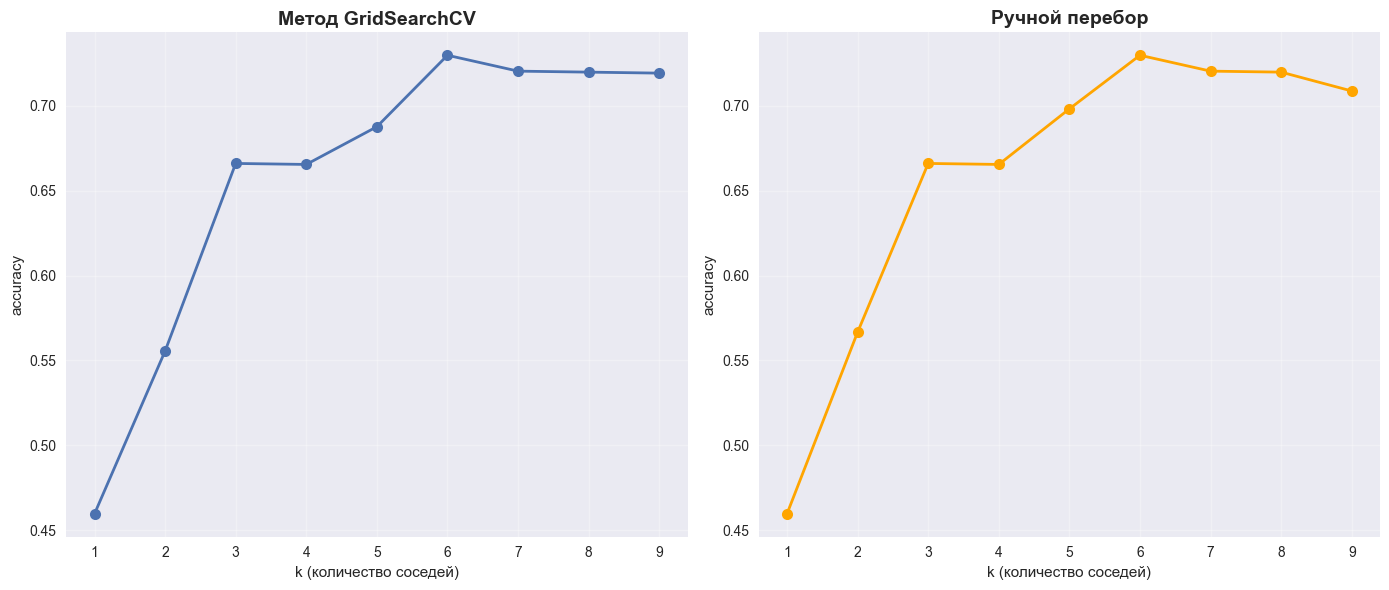

Сравнение методов:
GridSearchCV
k = 6
accuracy - 0.7298
--------------------
Ручной метод
k = 6
accuracy - 0.7298


In [24]:
n = len(X_train)
max_k = min(20, n // 10)  
k_range = range(1, max_k + 1)

# GridSearchCV
knn_pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("knn", KNeighborsClassifier())
])

knn_params = {"knn__n_neighbors": k_range}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, scoring='accuracy', return_train_score=True)
knn_grid.fit(X_train, y_train)
knn_pred = knn_grid.predict(X_test)

# Ручной перебор
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

plt.figure(figsize=(14, 6))

# GridSearchCV
plt.subplot(1, 2, 1)
results = knn_grid.cv_results_
k_values = knn_params['knn__n_neighbors']
mean_scores = results['mean_test_score']

plt.plot(k_values, mean_scores, marker='o', linewidth=2, markersize=8)
plt.title('Метод GridSearchCV', fontsize=14, fontweight='bold')
plt.xlabel('k (количество соседей)')
plt.ylabel('accuracy')
plt.grid(True, alpha=0.3)

# Ручной перебор
plt.subplot(1, 2, 2)
plt.plot(k_range, k_scores, marker='o', linewidth=2, markersize=8, color='orange')
plt.title('Ручной перебор', fontsize=14, fontweight='bold')
plt.xlabel('k (количество соседей)')
plt.ylabel('accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Сравнение методов:")
print("GridSearchCV")
best_k1 = knn_grid.best_params_['knn__n_neighbors']
best_score1 = knn_grid.best_score_
print(f"k = {best_k1}")
print(f"accuracy - {best_score1:.4f}")

print("-" * 20)
print("Ручной метод")
best_k2 = k_range[np.argmax(k_scores)]
best_score2 = max(k_scores)
print(f"k = {best_k2}")
print(f"accuracy - {best_score2:.4f}")

#### 3.2 Дерево решений:

Fitting 5 folds for each of 42 candidates, totalling 210 fits
accuracy: 0.75


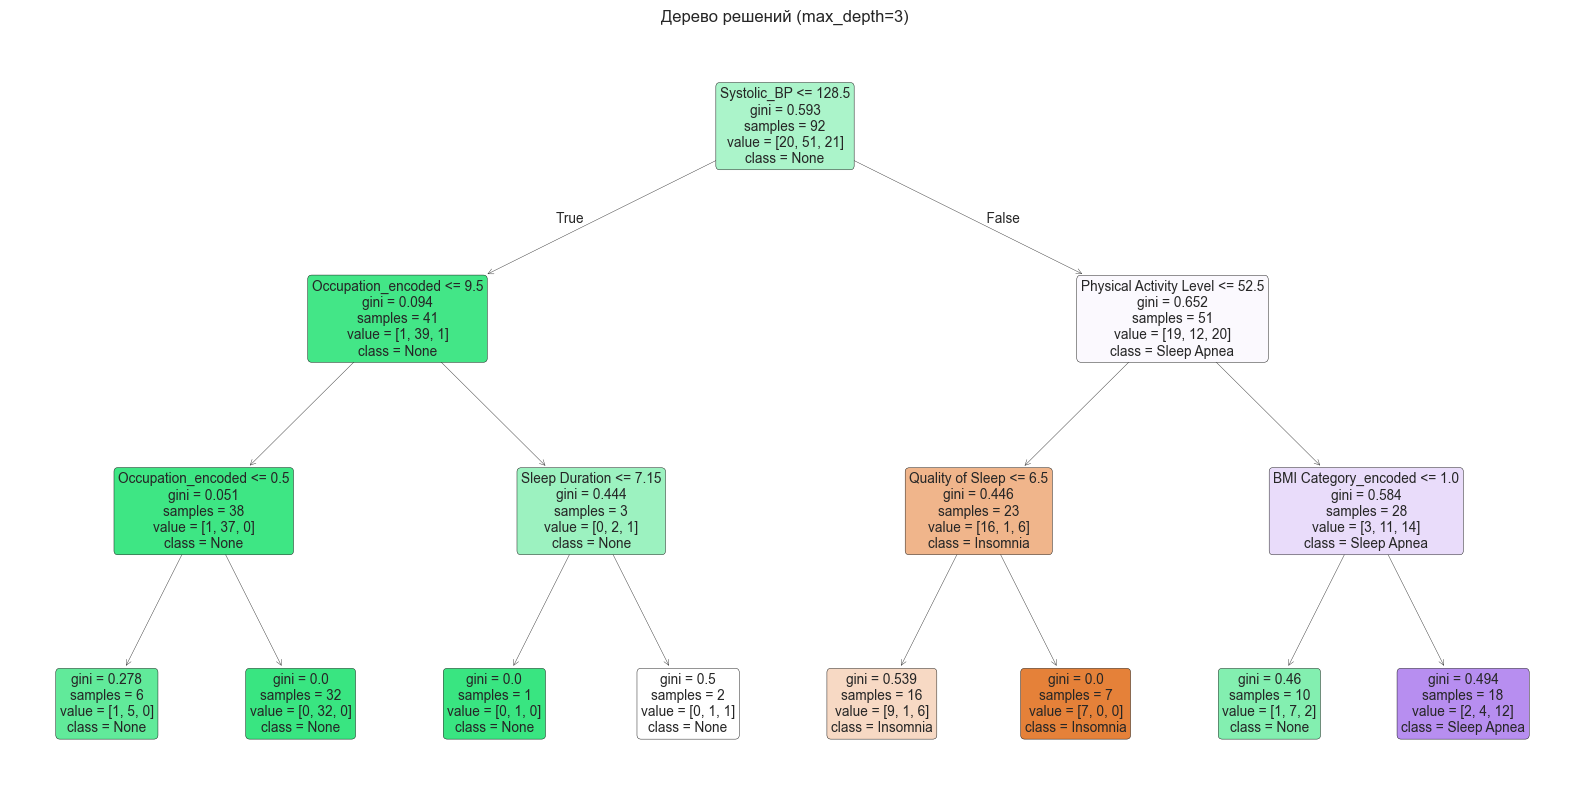

Таблица важности признаков:
                    feature  importance
10              Systolic_BP    0.586397
3   Physical Activity Level    0.222667
9      BMI Category_encoded    0.096229
2          Quality of Sleep    0.054883
8        Occupation_encoded    0.028640
1            Sleep Duration    0.011183
0                       Age    0.000000
4              Stress Level    0.000000
7            Gender_encoded    0.000000
6               Daily Steps    0.000000
5                Heart Rate    0.000000
11             Diastolic_BP    0.000000


In [25]:
n_features = X.shape[1]
n_samples = X.shape[0]
tree_params = {
    'max_depth': range(3, min(25, n_features * 2)),  
    'min_samples_leaf': range(1, max(2, n_samples // 50)),  
    'min_samples_split': range(2, max(3, n_samples // 30))
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=17), 
    tree_params, 
    cv=5, 
    scoring='accuracy',
    verbose=True
)

tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_
tree_pred = best_tree.predict(X_test)

print("accuracy:", accuracy_score(y_test, tree_pred))
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=X.columns,
          class_names=best_tree.classes_, 
          filled=True,
          rounded=True)
plt.title(f"Дерево решений (max_depth={tree_grid.best_params_['max_depth']})")
plt.show()

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_tree.feature_importances_
}).sort_values('importance', ascending=False)

print("Таблица важности признаков:")
print(feature_importance)

### 4. Сравние результатов с помощью метрик оценки качества:

In [26]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"{model_name}")
    print('-' * 30)
    print(f"Accuracy:        {accuracy:.4f}")
    print(f"Precision:       {precision:.4f}")
    print(f"Recall:          {recall:.4f}")
    print(f"F-measure (β=1): {f1:.4f}")
    print()
    
    return accuracy, precision, recall, f1

print("Сравнение мерик оценки качества:\n")
knn_metrics = evaluate_model(y_test, knn_pred, "kNN")
print('-' * 30)
tree_metrics = evaluate_model(y_test, tree_pred, "Дерево решений")

Сравнение мерик оценки качества:

kNN
------------------------------
Accuracy:        0.6750
Precision:       0.6963
Recall:          0.6750
F-measure (β=1): 0.6781

------------------------------
Дерево решений
------------------------------
Accuracy:        0.7500
Precision:       0.7515
Recall:          0.7500
F-measure (β=1): 0.7458



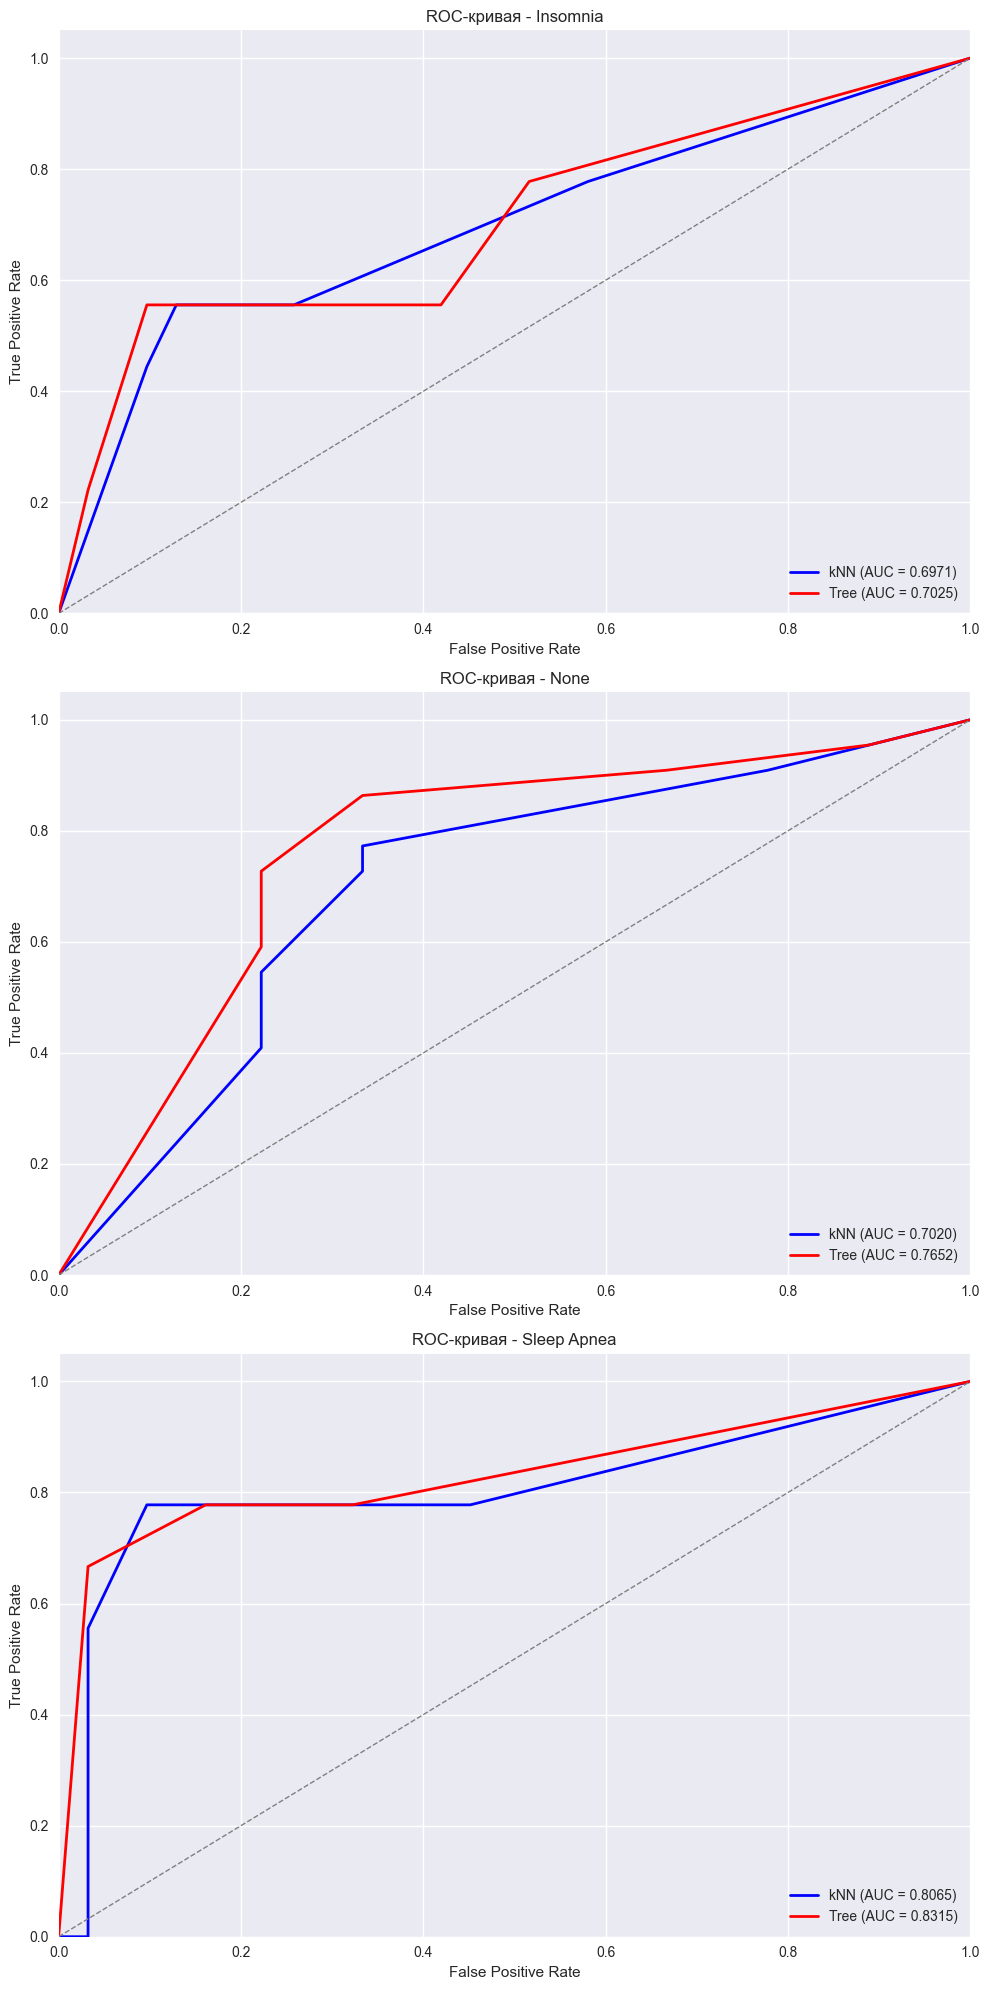

In [28]:
y_test_bin = label_binarize(y_test, classes=best_tree.classes_)
knn_proba = knn_best.predict_proba(X_test_scaled)
tree_proba = best_tree.predict_proba(X_test)

# ROC-кривые
n_classes = len(best_tree.classes_)
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
axes = axes.ravel()

for i, class_name in enumerate(best_tree.classes_):
    # kNN ROC
    fpr_knn, tpr_knn, _ = roc_curve(y_test_bin[:, i], knn_proba[:, i])
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    # Tree ROC
    fpr_tree, tpr_tree, _ = roc_curve(y_test_bin[:, i], tree_proba[:, i])
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    
    axes[i].plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'kNN (AUC = {roc_auc_knn:.4f})')
    axes[i].plot(fpr_tree, tpr_tree, color='red', lw=2, label=f'Tree (AUC = {roc_auc_tree:.4f})')
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC-кривая - {class_name}')
    axes[i].legend(loc="lower right")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### 5. Анализ полученных результатов:
- Проведена предобработка данных перед применением алгоритмов классификации: отчистка, обработка категориальных переменных, разделение на train и test (выделили 70% выборки под обучение и 30% являются отложенной выборкой) и анализ дисбаланса (данные несбалансированны)
- kNN:
  * методы GridSearchCV и Ручной перебор показали одинаковые результаты: k = 6
accuracy - 0.7298
  * при k от 1 до 3 точность резко возрастает, то есть модель склонна к переобучению, чувствительна к шуму и случайным выбросам в обучающей выборке
  * кривая достигает пика при k = 6, в этой точке достигается наилучший баланс между чувствительностью к шуму и способностью учитывать структуру данных
  * при k > 6 модель становится менее чувствительной к отдельным объектам и шуму, что ведёт к снижению точности
- Дерево решений:
  * точность модели составляет 0.75, что говорит о довольно хорошем качестве классификации
  * самыми важными признаками для классификации являются: Systolic_BP, Physical Activity Level, BMI Category_encoded, Quality of Sleep - используются для расщепления данных на узлах дерева
  * признаки с нулевой важностью практически не используются моделью при принятии решения — либо они не связаны с целевым классом, либо они коррелированы с другими признаками и не дают дополнительной информации
- Сравнение алгоритмов классификации:
  * модель дерева решений лучше справляется с задачей классификации на данном наборе данных, то есть более надёжно и всесторонне определяет целевые классы.
  * по всем метрикам она менее подвержена ошибкам ложных срабатываний (FP) и отсутствующих данных, а также имеет более высокую accuracy
  * kNN уступает дереву решений, возможно, из-за отсутствия оптимальных признаков или чувствительности к выбору параметра k и структуре данных
  * анализ ROC-кривых показал, что обе модели демонстрируют результаты выше случайного классификатора (диагональная линия):
    - Insomnia: обе модели демонстрируют практически одинаковую удовлетворительную эффективность в определении бессонницы. AUC = 0.6971 и AUC = 0.7025, означает, что модели правильно ранжируют около 70% пар объектов;
    - None: дерево решений превосходит kNN в определении здоровых пациентов. AUC = 0.7652 и 0.7020 указывает на лучшую разделяющую способность дерева. Это может быть связано с тем, что признаки здорового сна имеют более четкие паттерны, которые лучше выделяются деревом решений;
    - Sleep apnea: обе модели показывают хорошее качество в диагностике апноэ сна, с небольшим преимуществом дерева решений (AUC = 0.8315 и AUC = 0.8065). Значения AUC > 0.8 свидетельствуют о высокой предсказательной способности для этого медицинского состояния.